# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

<!--  -->

# **PARTE A**: Exploración de Datos

### 1. Preparación del Dataset

In [1]:
# Importamos las librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima_model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from matplotlib.ticker import MaxNLocator
from scipy.stats import chi2_contingency

import warnings

C:\Users\RY27844\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# Desactivamos los warnings
warnings.filterwarnings(action = 'ignore')

In [3]:
# Deshabilitar maximo de 5000 observaciones de la libreria altair
# alt.data_transformers.disable_max_rows()

In [4]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep = ',') # datos correspondiente al 2019
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep = ',') # datos correspondiente al 2018
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep = ',') # datos correspondiente al 2017

<!--  -->

Imprimimos información de cada variable y las 5 primeras observaciones para cada dataset:

In [5]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [6]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [7]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


<!--  -->

Podemos observar que disponemos de variables de tipo categoricas y numericas, sin presencia de datos nulos. Ahora imprimios la descripcion numerica y categorica de las variables que contiene el dataset:

In [8]:
print(data_2017.describe(include = 'number')); print('\n') # Descripcion variables numericas
print(data_2017.describe(exclude = 'number')) # Descripcion variables categoricas

         periodo   hora_inicio      hora_fin  cantidad_pasos
count  1372645.0  1.372645e+06  1.372645e+06    1.372645e+06
mean      2017.0  1.197077e+01  1.210050e+01    9.094375e+01
std          0.0  6.571334e+00  6.641892e+00    3.016382e+02
min       2017.0  0.000000e+00  0.000000e+00    1.000000e+00
25%       2017.0  7.000000e+00  7.000000e+00    2.000000e+00
50%       2017.0  1.200000e+01  1.200000e+01    7.000000e+00
75%       2017.0  1.700000e+01  1.800000e+01    2.800000e+01
max       2017.0  2.300000e+01  2.300000e+01    4.271000e+03


             fecha      dia    estacion    sentido tipo_vehiculo forma_pago
count      1372645  1372645     1372645    1372645       1372645    1372645
unique         365        7           8          2             2          8
top     2017-05-05  Viernes  Avellaneda  Provincia        Pesado   EFECTIVO
freq          4144   206826      391842     768448        774210     447203


In [9]:
print(data_2018.describe(include = 'number')); print('\n') # Descripcion variables numericas
print(data_2018.describe(exclude = 'number')) # Descripcion variables categoricas

         periodo   hora_inicio      hora_fin  cantidad_pasos
count  1375908.0  1.375908e+06  1.375908e+06    1.375908e+06
mean      2018.0  1.198040e+01  1.211807e+01    8.946361e+01
std          0.0  6.538943e+00  6.610977e+00    2.910907e+02
min       2018.0  0.000000e+00  0.000000e+00    1.000000e+00
25%       2018.0  7.000000e+00  7.000000e+00    2.000000e+00
50%       2018.0  1.200000e+01  1.200000e+01    6.000000e+00
75%       2018.0  1.700000e+01  1.800000e+01    2.600000e+01
max       2018.0  2.300000e+01  2.300000e+01    5.722000e+03


             fecha      dia    estacion    sentido tipo_vehiculo forma_pago
count      1375908  1375908     1375908    1375908       1375908    1375908
unique         365        7           8          2             2          6
top     2018-12-07  Viernes  Avellaneda  Provincia        Pesado   TELEPASE
freq          4305   208767      394371     779678        757635     429053


In [10]:
print(data_2019.describe(include = 'number')); print('\n') # Descripcion variables numericas
print(data_2019.describe(exclude = 'number')) # Descripcion variables categoricas

        periodo    hora_inicio       hora_fin  cantidad_pasos
count  812153.0  812153.000000  812153.000000   812153.000000
mean     2019.0      11.877101      11.957619      156.018047
std         0.0       6.676295       6.733530      387.348842
min      2019.0       0.000000       0.000000        1.000000
25%      2019.0       6.000000       7.000000        4.000000
50%      2019.0      12.000000      12.000000       15.000000
75%      2019.0      18.000000      18.000000       72.000000
max      2019.0      23.000000      23.000000     6677.000000


             fecha     dia    estacion    sentido tipo_vehiculo forma_pago
count       812153  812153      812153     812153        812153     812153
unique         365       7           8          2             2          6
top     2019-11-14  Martes  Dellepiane  Provincia       Liviano   TELEPASE
freq          2452  119187      187600     462729        479684     201388


<!--  -->

Investiguemos que valores toman los campos `estacion`, `sentido`, `tipo_vehiculo` y `forma_pago`:

In [6]:
# Imprimimos valores unicos de la variable `estacion`
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [12]:
# Imprimimos valores unicos de la variable `sentido`
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [13]:
# Imprimimos valores unicos de la variable `tipo_vehiculo`
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [14]:
# Imprimimos valores unicos de la variable `forma_pago`
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Ademas, la variable `forma_pago`, posee algunos valores diferentes segun el año del dataset, por lo que se procedera a estandarizarlos:

In [7]:
# Reemplazo de uno de las clases de `forma_pago` del año 2019
data_2019['forma_pago'].replace({'T. DISCAPACIDAD': 'TARJETA DISCAPACIDAD'}, inplace = True)
print(data_2019['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'TARJETA DISCAPACIDAD']


In [8]:
data_2017['estacion'].replace({'Dellepiane Centro': 'Dellepiane',
                                'Dellepiane Liniers': 'Dellepiane'}, inplace = True)
data_2018['estacion'].replace({'Dellepiane Centro': 'Dellepiane',
                                'Dellepiane Liniers': 'Dellepiane'}, inplace = True)
print(data_2018['estacion'].unique(), '\n', data_2017['estacion'].unique())

['Alberdi' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento'] 
 ['Alberdi' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento']


In [9]:
# Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
peajes_full = pd.concat([data_2019, data_2018, data_2017])

<!--  -->

### ANALISIS UNIVARIADO

#### 1) VARIABLES CATEGORICAS vs. CONTINUAS

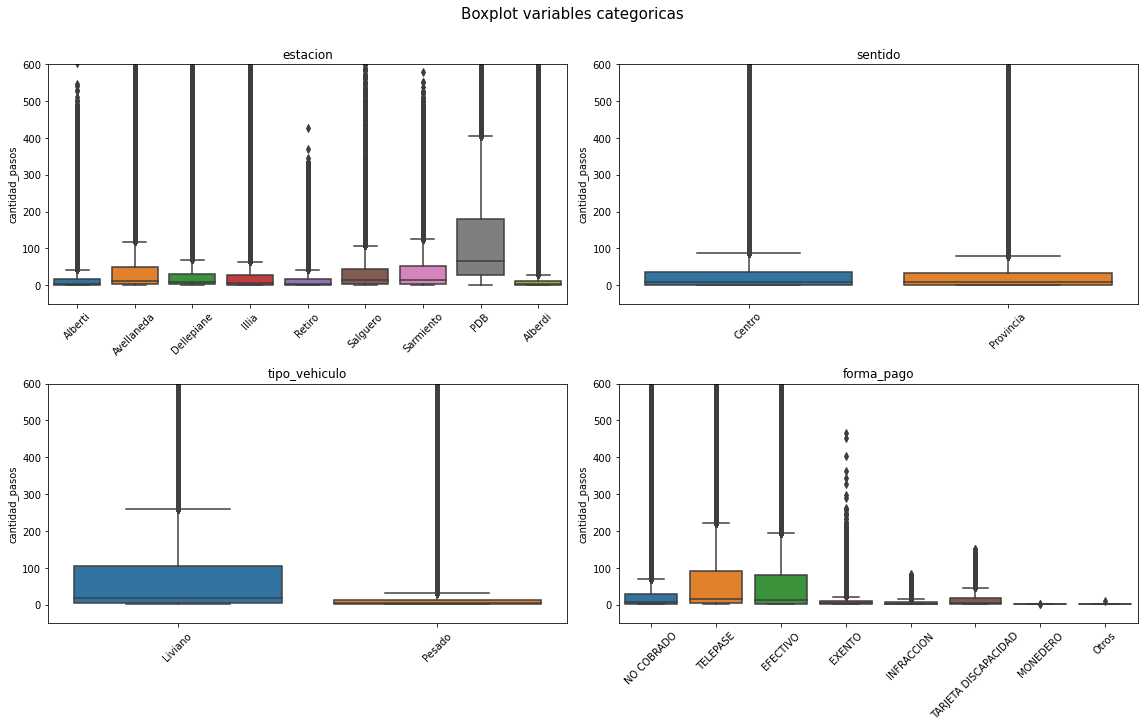

In [10]:
var_cat = ['estacion', 'sentido','tipo_vehiculo', 'forma_pago'] # lista de variables categoricas

a = 2 # Numero de filas del subplot
b = 2 # Numero de columnas del subplot
c = 1 # Iniciador del contador

fig = plt.figure(figsize = (16, 10))

# Graficamos un boxplot por cada variable categorica
for cat in var_cat:
    plt.subplot(a, b, c)
    ax = sns.boxplot(data = peajes_full, y = 'cantidad_pasos', x = cat)
    plt.suptitle('Boxplot variables categoricas', fontsize = 15, y = 1.007)
    ax.set_title(f'{cat}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    ax.set_ylim(-50, 600)
    ax.set(xlabel = None)
    c = c + 1 # Contador
    
plt.tight_layout()
plt.show()

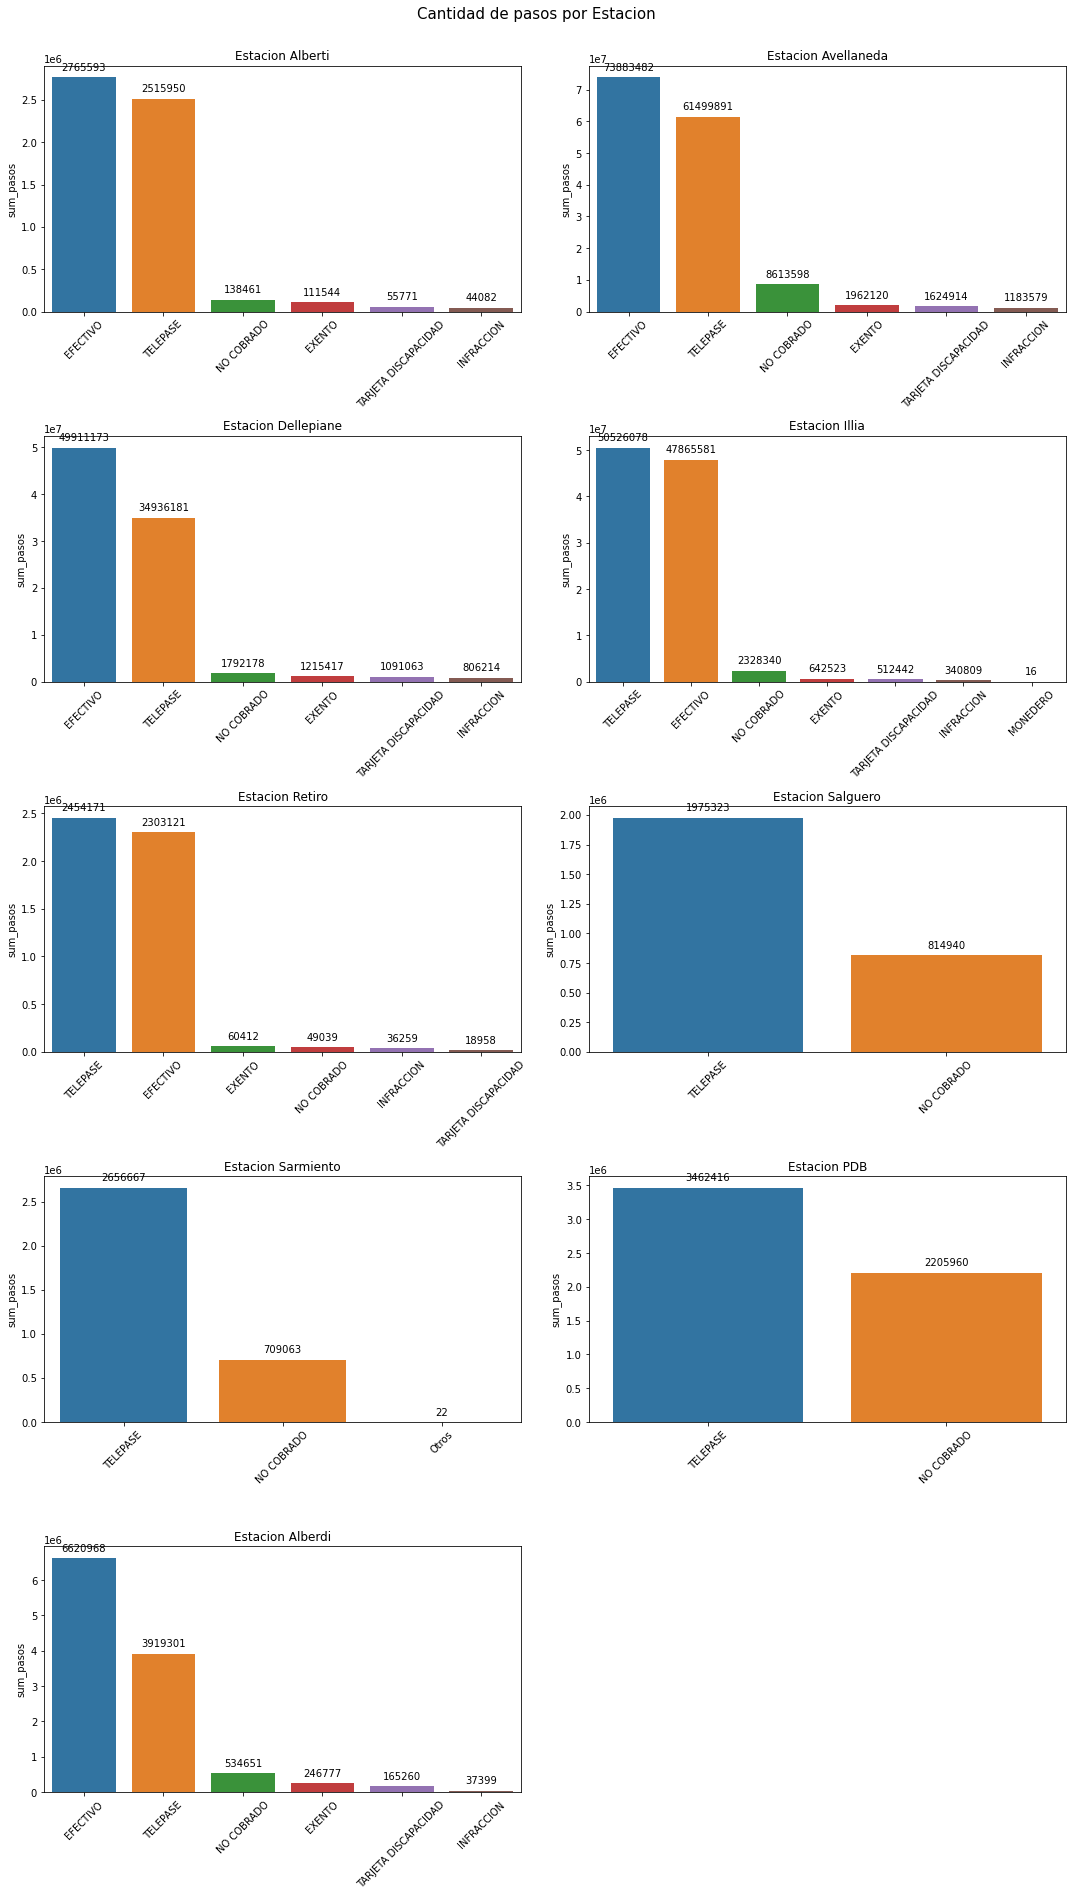

numexpr.utils INFO  NumExpr defaulting to 8 threads.


,estacion,sum_pasos,peso %
2,Avellaneda,148767584,39.7
4,Illia,102215789,27.3
3,Dellepiane,89752226,24.0
0,Alberdi,11524356,3.1
5,PDB,5668376,1.5
1,Alberti,5631401,1.5
6,Retiro,4921960,1.3
8,Sarmiento,3365752,0.9
7,Salguero,2790263,0.7


None


,forma_pago,cantidad_pasos,% peso
0,EFECTIVO,183349918,48.9
7,TELEPASE,163945978,43.8
4,NO COBRADO,17186230,4.6
1,EXENTO,4238793,1.1
6,TARJETA DISCAPACIDAD,3468408,0.9
2,INFRACCION,2448342,0.7
5,Otros,22,0.0
3,MONEDERO,16,0.0


In [11]:
estaciones = ['Alberti', 'Avellaneda', 'Dellepiane', 'Illia', 'Retiro', 'Salguero', 'Sarmiento', 'PDB', 'Alberdi'] # lista de estaciones

a = 6 # Numero de filas del subplot
b = 2 # Numero de columnas del subplot
c = 1 # Iniciador del contador

fix, ax = plt.subplots(figsize = (15, 30))

# Graficos de barras para el conteo de pasos por forma_pago por cada estacion
for estacion in estaciones:
    plt.subplot(a, b, c)
    data = peajes_full.loc[peajes_full['estacion'] == estacion]
    data = data['cantidad_pasos'].groupby(data['forma_pago']).sum().reset_index(name = 'sum_pasos').sort_values(by = 'sum_pasos', ascending = False)
    ax = sns.barplot(data = data, x = 'forma_pago', y = 'sum_pasos')
    for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height() + 10), ha = 'center', va = 'center', xytext = (0, 10),
                             textcoords = 'offset pixels') # Agregamos las etiquetas de cada barra del grafico
    plt.suptitle('Cantidad de pasos por Estacion', fontsize = 15, y = 1.003)
    ax.set_title(f'Estacion {estacion}')
    ax.set(xlabel = None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45) # Rotacion a 45 grados de las etiquetas del eje x
    c = c + 1 # Contador

plt.tight_layout()
plt.show()

# Imprimimos un dataframe del peso de en observaciones por estacion segun la suma de cantidad_pasos
data = peajes_full['cantidad_pasos'].groupby(peajes_full['estacion']).sum().reset_index(name = 'sum_pasos').sort_values(by = 'sum_pasos', ascending = False)
data['peso %'] = round((data['sum_pasos'] / peajes_full['cantidad_pasos'].sum()) * 100, 1) # Peso en porcentaje por estacion
print(display(data))

# Similar al dataframe anterior pero por forma de pago
data = peajes_full['cantidad_pasos'].groupby(peajes_full['forma_pago']).sum().reset_index(name = 'cantidad_pasos')
data['% peso'] = round((data['cantidad_pasos'] / peajes_full['cantidad_pasos'].sum()) * 100, 1)
data.sort_values('cantidad_pasos', ascending = False)

Podemos observar que las formas de pago con mayor cantidad de pasos de vehiculo son `TELEPASE` y `EFECTIVO`, tendencia que se ve bien marcada en las 3 estaciones con mayor cantidad de observaciones y que representan un 91% del total de las observaciones, que son `Avellaneda`, `Illia` y `Dellepiane`.

In [20]:
# alt.Chart(peajes_full).mark_line(point = True).encode(
#     x = 'fecha:T', y = 'sum(cantidad_pasos):Q', column = 'periodo:N', tooltip = ['quarter(fecha):O', 'sum(cantidad_pasos)']).properties(
#     width = 300, height = 300)

## Analisis con Enfoque al modelado

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**.

In [21]:
# Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(peajes_full.estacion == 'Illia', peajes_full.forma_pago == 'EFECTIVO')
peajes = peajes_full[mask]

# Quitamos las columnas que no vamos a utilizar
peajes.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

peajes.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


<!--  -->

Analicemos el balance de observaciones existentes entre las diferentes clases de las variables categoricas `tipo_vehiculo` y `sentido`:

In [22]:
# Observaciones por `tipo_vehiculo`
data_vehiculo = peajes['cantidad_pasos'].groupby(peajes['tipo_vehiculo']).sum().reset_index(name = 'pasos')
data_vehiculo['peso %'] = round((data_vehiculo['pasos'] / peajes['cantidad_pasos'].sum()) * 100, 1)

# Observaciones por `sentido`
data_sentido = peajes['cantidad_pasos'].groupby(peajes['sentido']).sum().reset_index(name = 'pasos')
data_sentido['peso %'] = round((data_sentido['pasos'] / peajes['cantidad_pasos'].sum()) * 100, 1)

print(display(data_vehiculo))
print('\n')
print(display(data_sentido))

,tipo_vehiculo,pasos,peso %
0,Liviano,46338529,96.8
1,Pesado,1527052,3.2


None




,sentido,pasos,peso %
0,Centro,24707366,51.6
1,Provincia,23158215,48.4


None


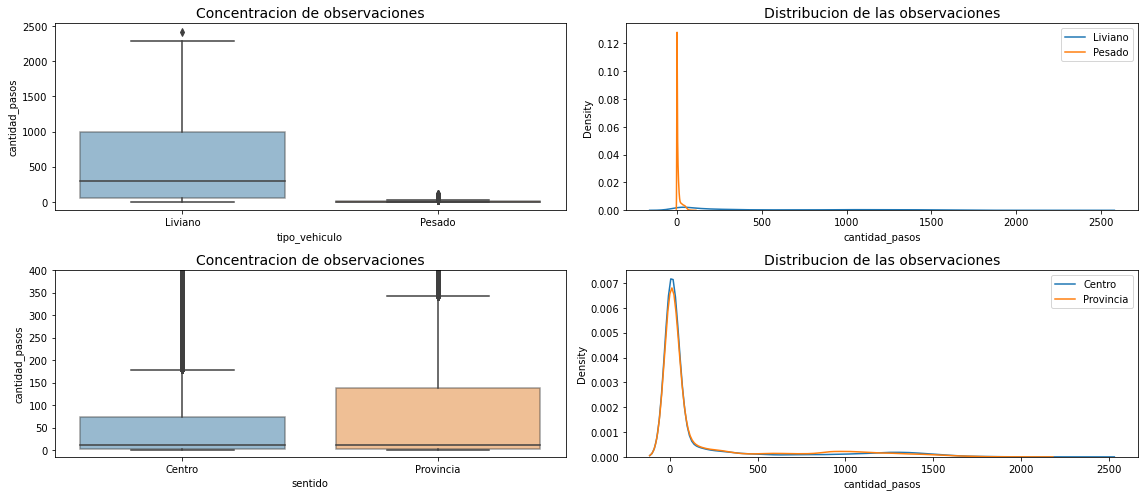

In [23]:
# Distribucion de las variables `tipo_vehiculo` y `sentido` 

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 7))

# 1) Para `tipo_vehiculo` ///////////////////////////////////////////////////////////////////////////////////////////////////
# Graficamos un boxplot
sns.boxplot(data = peajes, x = 'tipo_vehiculo', y = 'cantidad_pasos', ax = ax[0, 0], boxprops = dict(alpha = 0.5))
ax[0, 0].set_title('Concentracion de observaciones', fontsize = 14)

# Graficamos la distribucion de los datos
sns.distplot(peajes[peajes['tipo_vehiculo'] == 'Liviano']['cantidad_pasos'], label = 'Liviano', hist = False, ax = ax[0, 1])
sns.distplot(peajes[peajes['tipo_vehiculo'] == 'Pesado']['cantidad_pasos'], label = 'Pesado', hist = False, ax = ax[0, 1])
ax[0, 1].legend(loc = 'upper right')
ax[0, 1].set_title('Distribucion de las observaciones', fontsize = 14)


# 2) Para `sentido` ////////////////////////////////////////////////////////////////////////////////////////////////////////
# Graficamos un boxplot
sns.boxplot(data = peajes, x = 'sentido', y = 'cantidad_pasos', ax = ax[1, 0], boxprops = dict(alpha = 0.5))
ax[1, 0].set_title('Concentracion de observaciones', fontsize = 14)
ax[1, 0].set_ylim(-15, 400)

# Graficamos la distribucion de los datos
sns.distplot(peajes[peajes['sentido'] == 'Centro']['cantidad_pasos'], label = 'Centro', hist = False, ax = ax[1, 1])
sns.distplot(peajes[peajes['sentido'] == 'Provincia']['cantidad_pasos'], label = 'Provincia', hist = False, ax = ax[1, 1])
ax[1, 1].legend(loc = 'upper right')
ax[1, 1].set_title('Distribucion de las observaciones', fontsize = 14)


plt.tight_layout()
plt.show()

Debido principalmente a la baja cantidad de observaciones en vehiculo del tipo `Pesado`, pero ademas, a la gran diferencia entre distribuciones, las observaciones del tipo vehiculo `Pesado` seran eliminadas.
Las observaciones segun `sentido` por clase se encuentran balanceadas y la distribucion de los datos es similar.

In [24]:
# Procedemos a qudarnos unicamente con las observaciones de `tipo_vehiculo` = Liviano
peajes = peajes.loc[peajes['tipo_vehiculo'] == 'Liviano']
peajes.tipo_vehiculo.unique()

array(['Liviano'], dtype=object)

In [25]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
peajes['fecha2'] = pd.to_datetime(peajes.fecha) + pd.to_timedelta(peajes.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
peajes.drop(columns=['fecha','hora_fin'], inplace = True)

peajes.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00
158,Martes,Provincia,Liviano,597,2019-01-01 03:00:00
223,Martes,Centro,Liviano,597,2019-01-01 04:00:00


In [26]:
#Corregimos el nombre de fecha2 a fecha
peajes.rename(columns = {'fecha2': 'fecha'}, inplace = True) 
peajes.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00
158,Martes,Provincia,Liviano,597,2019-01-01 03:00:00
223,Martes,Centro,Liviano,597,2019-01-01 04:00:00


In [27]:
#Reordenamos el dataset por fecha
peajes.sort_values('fecha', inplace = True)
peajes.reset_index(drop=True, inplace = True)
peajes

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Centro,Liviano,23,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
3,Domingo,Centro,Liviano,857,2017-01-01 00:00:00
4,Domingo,Centro,Liviano,1,2017-01-01 01:00:00
...,...,...,...,...,...
87343,Martes,Provincia,Liviano,905,2019-12-31 21:00:00
87344,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
87345,Martes,Centro,Liviano,580,2019-12-31 22:00:00
87346,Martes,Centro,Liviano,214,2019-12-31 23:00:00


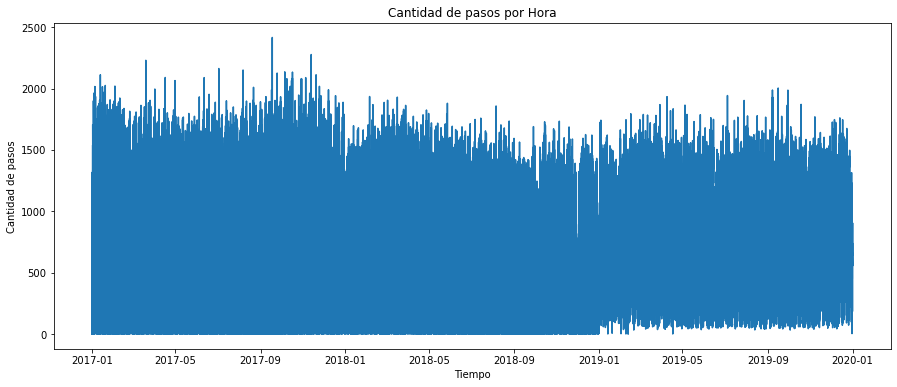

In [28]:
#Graficamos nuestros datos, tal como estan
plt.figure(figsize = (15,6))
plt.plot(peajes.fecha, peajes.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.title('Cantidad de pasos por Hora')
plt.show()

In [29]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = peajes.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,30641
2017-01-02,48979
2017-01-03,48322
2017-01-04,50581
2017-01-05,53622


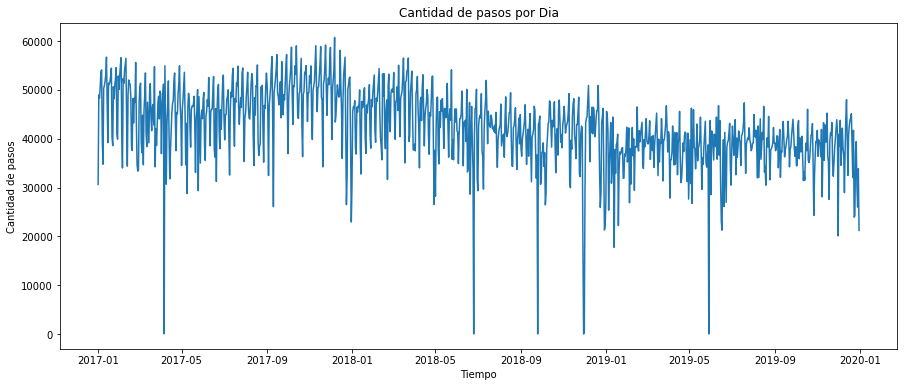

In [30]:
# Graficamos los datos resamplados por dia
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.title('Cantidad de pasos por Dia')
plt.show()

In [31]:
# Buscamos cuales son los dias que caen por debajo de los 1000 pasos diarios
diario.loc[diario['cantidad_pasos'] <= 1000]

,cantidad_pasos
fecha,
2017-04-06,40
2018-06-25,0
2018-09-25,0
2018-11-30,0
2018-12-01,343
2019-05-29,0


<AxesSubplot:xlabel='cantidad_pasos'>

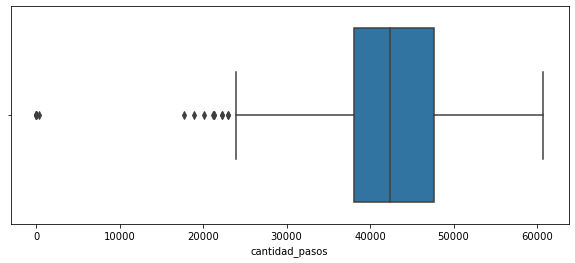

In [32]:
# Grafico tipo boxplot para detectar los outliers
plt.figure(figsize = (10, 4))
sns.boxplot(data = diario, x = 'cantidad_pasos')

Podemos ver en el grafico de cantidad de pasos diarios que hay determinadas observaciones que, ademas de considerarse como outliers, los valores de estas observaciones son realmente muy bajos, por lo que estos pueden deberse a alguna situacion marcada o particular de esos dias. De acuerdo a esto, se colocan los links de los eventos ocurridos durante los dias con una cantidad inferior a 1000 pasos diarios, tal como se remarco en la tabla expuesta anteriormente:

- 06/04/2017: https://www.lanacion.com.ar/politica/paro-del-6-de-abril-general-cgt-servicios-nid2005425/
- 25/06/2018: https://www.lanacion.com.ar/politica/paro-del-25-de-junio-donde-seran-los-principales-cortes-nid2147157/
- 25/09/2018: https://tn.com.ar/sociedad/los-cortes-de-calle-del-martes-25-de-septiembre-de-2018_899951/
- 30/11/2018: https://tn.com.ar/sociedad/los-cortes-de-calles-por-el-g20-viernes-30-de-noviembre-de-2018_920877/
- 01/12/2018: misma situacion que el dia anterior (30/11/2018) ya que la Cumbre del G-20 se realizo en ambos dias.
- 29/05/2019: https://www.lanacion.com.ar/sociedad/paro-general-mapa-cortes-transito-nid2252489/

De acuerdo al analisis realizado, pudimos observar en qué dias hay datos faltantes, es decir, no hubo pasos de vehiculos en la estacion Illia, y pudimos ver que tenemos presencia de datos atipicos o outliers en funcion del boxplot realizado. En principio podemos hacer mencion de dos puntos:

- **Deteccion y eliminacion de outliers**: al estar trabajando con series de tiempo, la eliminacion de datos atipicos que implique que un punto temporal ("dias" en este caso) tenga una cantidad de observaciones igual a cero, generara una interrupcion en la linea temporal de los datos, por lo que no pueden ser eliminados.
- **Imputacion de valores faltantes**: cuando se realizo el resampleo, se detecto que algunos puntos temporales no tenian observaciones, por lo que se podria proceder a aplicar algunas tecnicas o estrategias para poder rellenar estos espacios vacios.

En funcion de lo mencionado anteriormente, se procedera a imputar todos aquellos puntos temporales o dias que caigan sobre el area de *outliers*, en los que no solamente se incluyen los datos atipicos sino que tambien incluye los puntos temporales con valores faltantes o, lo mismo que decir, con observaciones iguales a cero:

In [33]:
# Creacion de una columna para detectar outliers, donde se coloca 1 si es outlier
q1 = diario.quantile(0.25) # variable para Q1
q3 = diario.quantile(0.75) # variable para Q3
iqr = q3 - q1 # calculo del rango intercuartilico
li = (q1 - 1.5 * iqr) # limite inferior del intervalo
ls = (q3 + 1.5 * iqr) # limite superior del intervalo
diario['outlier'] = diario['cantidad_pasos'].apply(lambda x: 0 if li['cantidad_pasos'] <= x <= ls['cantidad_pasos'] else 1) # 1 si es outlier, 0 si no lo es

In [34]:
# Observaciones detectados como outliers se convertiran en NaN
diario['cantidad_pasos_ref'] = diario['cantidad_pasos']
diario.loc[diario['outlier'] == 1, 'cantidad_pasos_ref'] = np.nan

In [35]:
# Contamos los datos nulos
diario.isna().sum()

cantidad_pasos         0
outlier                0
cantidad_pasos_ref    16
dtype: int64

In [36]:
# Eliminamos la columna utilizada para detectar las observaciones outliers
diario.drop(['outlier'], axis = 1, inplace = True)
diario.isna().sum()

cantidad_pasos         0
cantidad_pasos_ref    16
dtype: int64

<!--  -->

El proximo paso es realizar las imputaciones de los valores faltantes, que, en realidad, dependiendo de la estrategia seleccionada, no se realiza una imputacion como tal, sino, mas bien, una interpolacion de los datos. Las estrategias a utilizar seran las siguientes:

In [37]:
# Interpolacion mediante el metodo 'time'
diario = diario.assign(Int_time = diario.cantidad_pasos_ref.interpolate(method = 'time'))
# Interpolacion mediante el metodo 'linear'
diario = diario.assign(Int_linear = diario.cantidad_pasos_ref.interpolate(method = 'linear'))
# Interplacion mediante el metodo 'spline de orden 3'
diario = diario.assign(Int_spline3 = diario.cantidad_pasos_ref.interpolate(method = 'spline', order = 3))
# Interplacion mediante el metodo 'spline de orden 4'
diario = diario.assign(Int_spline4 = diario.cantidad_pasos_ref.interpolate(method = 'spline', order = 4))
# Interplacion mediante el metodo 'spline de orden 5'
diario = diario.assign(Int_spline5 = diario.cantidad_pasos_ref.interpolate(method = 'spline', order = 5))
# Interplacion mediante 'mean rolling window'
diario = diario.assign(RollingMean = diario.cantidad_pasos_ref.fillna(diario.cantidad_pasos_ref.rolling(24, min_periods = 1).mean()))
# Interplacion mediante el metodo 'median rolling window'
diario = diario.assign(RollingMedian = diario.cantidad_pasos_ref.fillna(diario.cantidad_pasos_ref.rolling(24, min_periods = 1).median()))

diario.drop('cantidad_pasos_ref', axis = 1, inplace = True) # eliminacion de la columna de cantidad de pasos utilizada como referencia

# Luego creamos un DataFrame con los resultados de las imputaciones
resultados = [(metodo, r2_score(diario.cantidad_pasos, diario[metodo])) for metodo in list(diario)[1:]]
resultados_df = pd.DataFrame(resultados, columns = ['metodo', 'r2'])
resultados_df.sort_values(by = 'r2', ascending = False)

,metodo,r2
3,Int_spline4,0.838892
2,Int_spline3,0.821765
4,Int_spline5,0.820985
0,Int_time,0.817116
1,Int_linear,0.817116
5,RollingMean,0.784895
6,RollingMedian,0.770496


Se utilizo r2 como metrica para medir el error de las imputaciones.

El metodo `Int_spline4` resulto como la mejor estrategia con un r2 de 83.9%. El resultado esperado para determinar si la mejor estrategia utilizada es buena es del 95%, quedando lejos de lo obtenido. 

Por la razon explicada anteriormente, es que se procedera a utilizar los datos sin ninguna imputacion ni eliminacion de outliers.

Graficaremos la mejor estrategia de imputacion y las observaciones originales para poder ver graficamente donde se presentan las mayores diferencias:

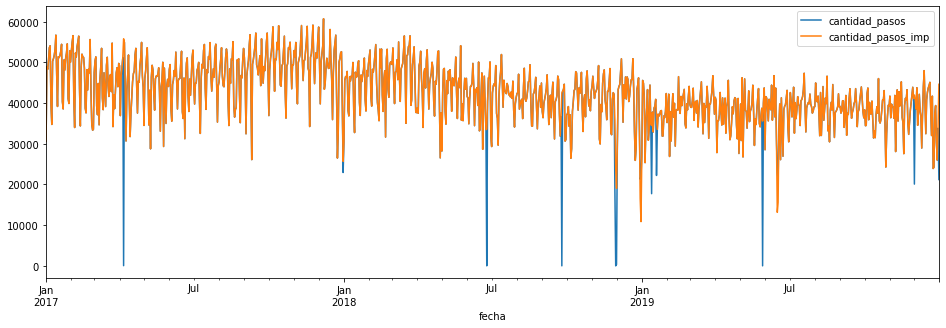

In [38]:
# Grafico de las observaciones originales vs. las imputadas
fix, ax = plt.subplots(figsize = (16, 5))

diario.cantidad_pasos.plot(ax = ax, label = 'cantidad_pasos')
diario.Int_spline4.plot(ax = ax, label = 'cantidad_pasos_imp')
plt.legend()
plt.tight_layout
plt.show()

In [39]:
# Eliminamos del DataFrame las columnas con las diferentes estrategias de imputacion utilizadas
metodos_lista = list(diario)[1:]

diario.drop(labels = metodos_lista, axis = 1, inplace = True)
diario.head()

,cantidad_pasos
fecha,
2017-01-01,30641
2017-01-02,48979
2017-01-03,48322
2017-01-04,50581
2017-01-05,53622


Hasta ahora veniamos hablando unicamente de la cantidad de pasos por dia, creando un resampleo a dia del DataFrame original. Ademas, a partir del DataFrame original, haremos un pequeño analisis en diferentes franjas temporales para observar el comportamiento de los datos:

In [40]:
# Columnas para diferentes variables de tiempo
peajes['anio'] = pd.DatetimeIndex(peajes['fecha']).year # columna Año
peajes['mes'] = pd.DatetimeIndex(peajes['fecha']).month # columna Mes
peajes['trimestre'] = pd.DatetimeIndex(peajes['fecha']).quarter # columna Trimestre
peajes['horario'] = pd.DatetimeIndex(peajes['fecha']).hour # columna Horario
peajes['semestre'] = np.where(peajes['trimestre'].isin([1, 2]), 1, 2) # columna Semestre
peajes['dia_semana'] = pd.DatetimeIndex(peajes['fecha']).dayofweek # columna Dia de la semana
peajes['dia_mes'] = pd.DatetimeIndex(peajes['fecha']).day # columna Numero del dia del mes
peajes.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha,anio,mes,trimestre,horario,semestre,dia_semana,dia_mes
0,Domingo,Centro,Liviano,23,2017-01-01 00:00:00,2017,1,1,0,1,6,1
1,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00,2017,1,1,0,1,6,1
2,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00,2017,1,1,0,1,6,1
3,Domingo,Centro,Liviano,857,2017-01-01 00:00:00,2017,1,1,0,1,6,1
4,Domingo,Centro,Liviano,1,2017-01-01 01:00:00,2017,1,1,1,1,6,1


In [41]:
# Dejamos la columna 'fecha' como indice
peajes.fecha = pd.to_datetime(peajes.fecha).dt.date
peajes = peajes.set_index('fecha')
peajes.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,anio,mes,trimestre,horario,semestre,dia_semana,dia_mes
fecha,,,,,,,,,,,
2017-01-01,Domingo,Centro,Liviano,23,2017,1,1,0,1,6,1
2017-01-01,Domingo,Provincia,Liviano,644,2017,1,1,0,1,6,1
2017-01-01,Domingo,Provincia,Liviano,9,2017,1,1,0,1,6,1
2017-01-01,Domingo,Centro,Liviano,857,2017,1,1,0,1,6,1
2017-01-01,Domingo,Centro,Liviano,1,2017,1,1,1,1,6,1


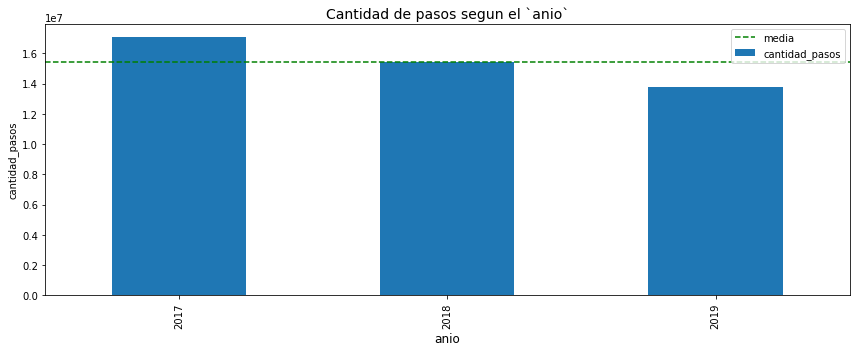

Diferencia en porcentaje entre valor minimo y valor maximo: 19.3%
---------------------------------------------------------------------------------------------------------------------- 



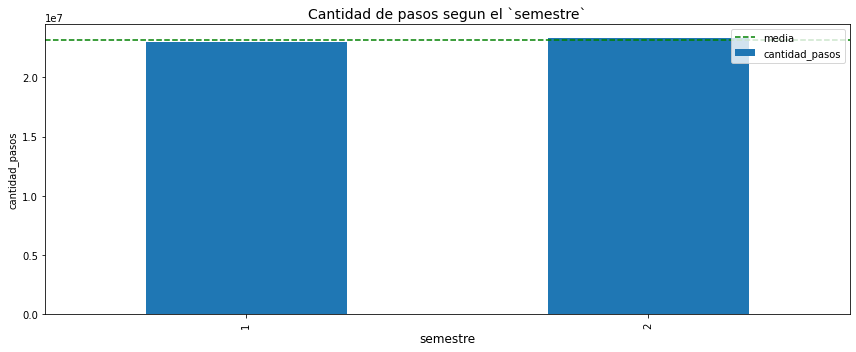

Diferencia en porcentaje entre valor minimo y valor maximo: 1.4%
---------------------------------------------------------------------------------------------------------------------- 



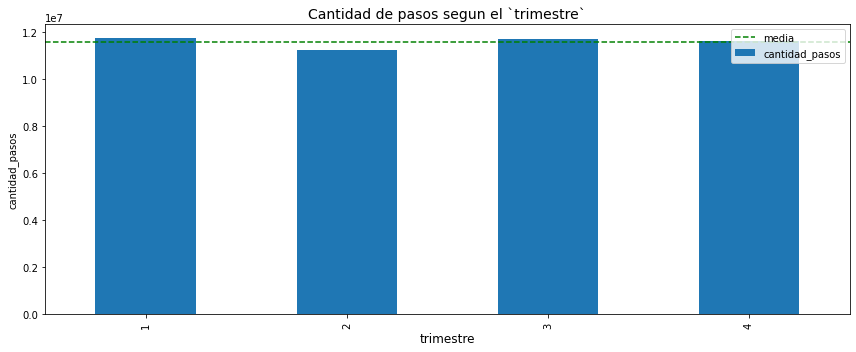

Diferencia en porcentaje entre valor minimo y valor maximo: 4.3%
---------------------------------------------------------------------------------------------------------------------- 



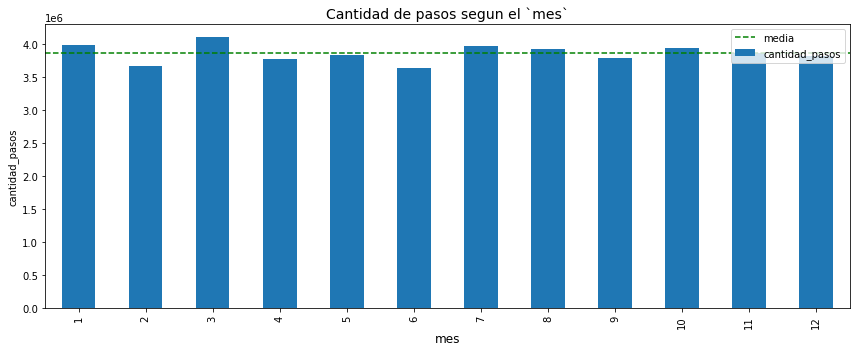

Diferencia en porcentaje entre valor minimo y valor maximo: 11.2%
---------------------------------------------------------------------------------------------------------------------- 



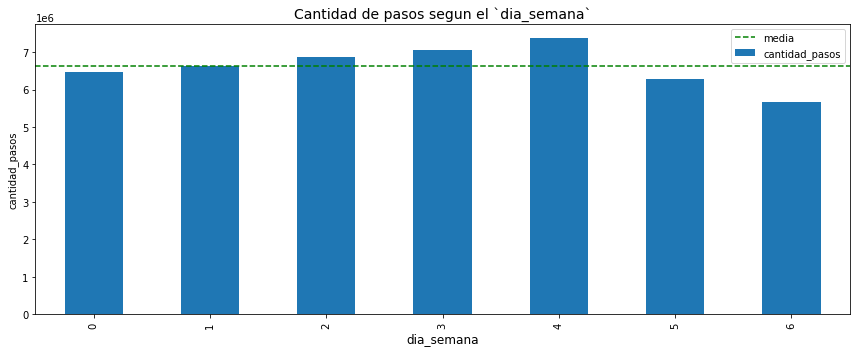

Diferencia en porcentaje entre valor minimo y valor maximo: 23.1%
---------------------------------------------------------------------------------------------------------------------- 



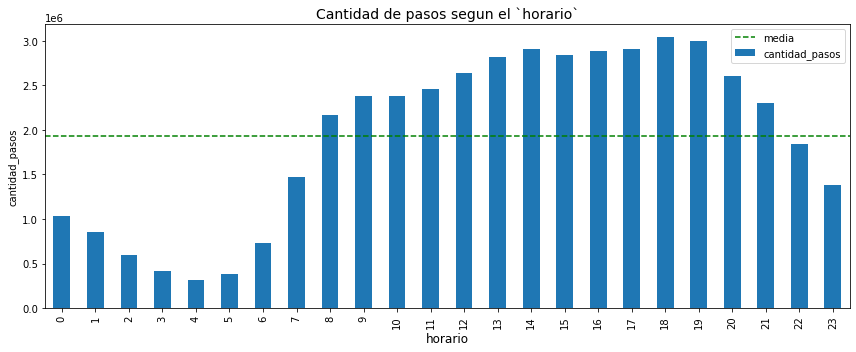

Diferencia en porcentaje entre valor minimo y valor maximo: 89.6%
---------------------------------------------------------------------------------------------------------------------- 



In [42]:
# Analizamos el comportamiento de 'cantidad_pasos' para las diferentes franjas temporales

times = ['anio', 'semestre', 'trimestre', 'mes', 'dia_semana', 'horario'] # Lista de variables de tiempo

# Visualizacion de tendecia segun diferentes variables de tiempo
for i in times:
    fig, ax = plt.subplots(figsize = (12, 5))
    # Agrupacion por variable de tiempo
    time = peajes['cantidad_pasos'].groupby(peajes[i]).sum()
    ax = time.plot(kind = 'bar', label = 'cantidad_pasos')
    ax.set_xlabel(i, fontsize = 12)
    ax.set_ylabel('cantidad_pasos')
    ax.set_title(f'Cantidad de pasos segun el `{i}`', fontsize = 14)
    # Promedio por variable de tiempo
    promedio = time.sum() / len(time.unique())
    ax.axhline(promedio, linestyle = '--', color = 'g', label = 'media')
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()
    # Diferencia valores minimos y maximos
    maximo = time.max()
    minimo = time.min()
    dif_minmax = round(100 - (minimo / maximo) * 100, 1)
    print(f'Diferencia en porcentaje entre valor minimo y valor maximo: {dif_minmax}%')
    print('---------------------------------------------------------------------------------------------------------------------- \n')

A partir del analisis de diferentes ventanas de tiempo podemos mencionar:

1) **Año**: se observa una tendencia negativa, con una caida aproximada del 20% en el periodo de tiempo analizado. Teniendo en cuenta que unicamente estamos tomando una unica forma de pago la cual es 'Efectivo', podria estar sucediendo que con el pasar del tiempo se fue migrando a otras formas de pago, como 'Telepase', por ejemplo.
2) **Semestre**: no se osberva tendencia o estacionalidad.
3) **Trimestre**: no se observa tendencia o estacionalidad.
4) **Mes**: no se observa tendencia o estacionalidad.
5) **Dia_semana**: siendo 0:lunes a 6:domingo, se observa una tendecia positiva acercandose al fin de semana, y una tendencia negativa finalizando el fin de semana.
6) **Horario**: no se observa tendencia pero si hay una clara estacionalidad por horario del dia, marcando una diferencia del casi 90% entre el horario con menos pasos y el de mayor cantidad de pasos.

Haremos la misma comparacion anterior pero diferenciandolo por año:

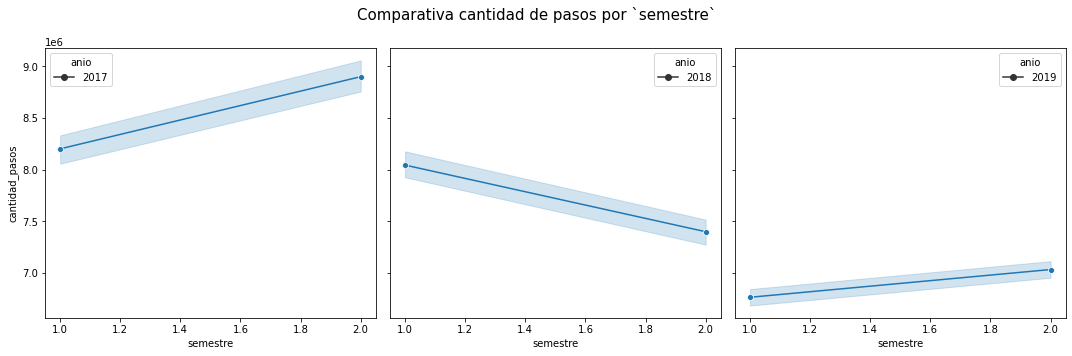



/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// 



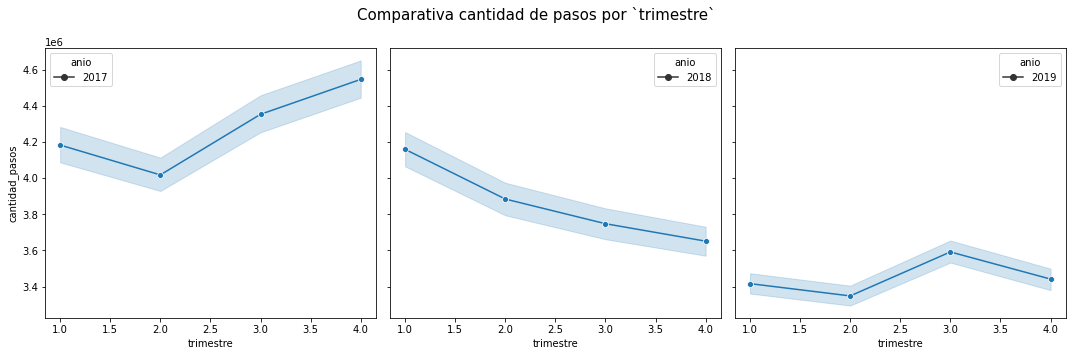



/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// 



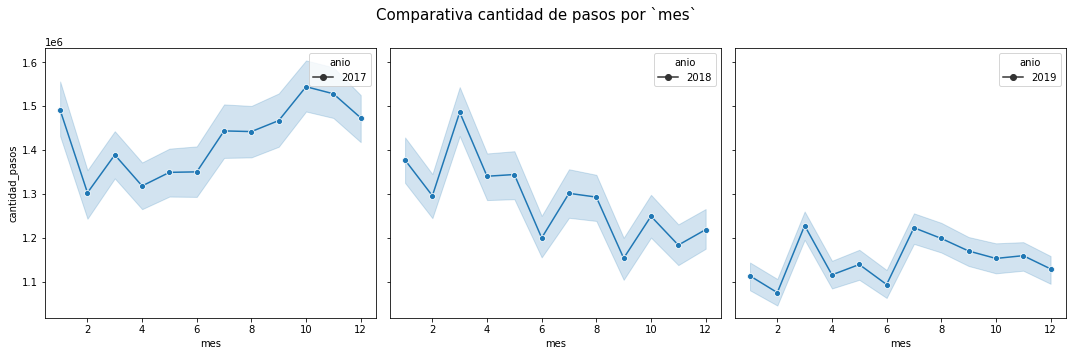



/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// 



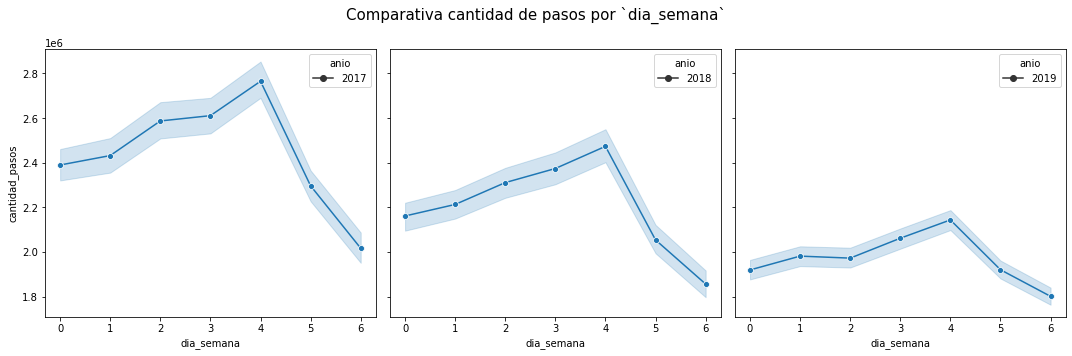



/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// 



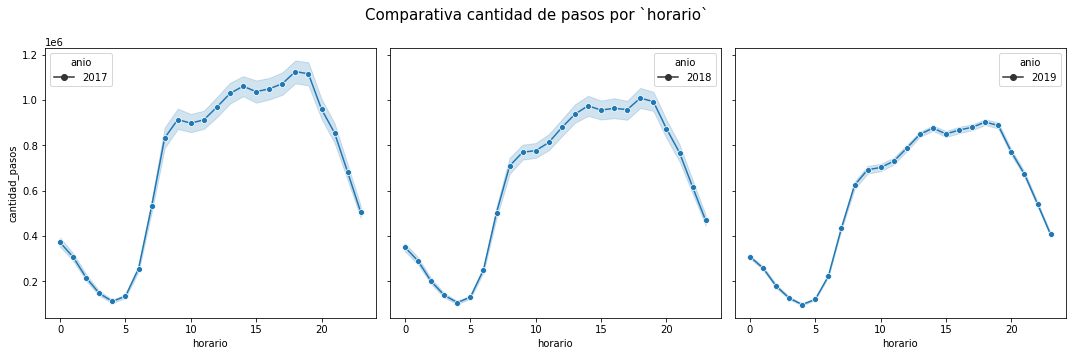



/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// 



In [43]:
times = ['semestre', 'trimestre', 'mes', 'dia_semana', 'horario'] # Lista de variables de tiempo

# Corremos un for loop para analizar cada variable de tiempo por año
for time in times:
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5), sharey = True)
    # Para el año 2017
    sns.lineplot(data = peajes[peajes['anio'] == 2017], x = time, y = 'cantidad_pasos', 
                 style = 'anio', estimator = 'sum', ax = ax[0], markers = True)
    
    # Para el año 2018
    sns.lineplot(data = peajes[peajes['anio'] == 2018], x = time, y = 'cantidad_pasos', 
                 style = 'anio', estimator = 'sum', ax = ax[1], markers = True)
    
    # Para el año 2019
    sns.lineplot(data = peajes[peajes['anio'] == 2019], x = time, y = 'cantidad_pasos', 
                 style = 'anio', estimator = 'sum', ax = ax[2], markers = True)
    
    plt.suptitle(f'Comparativa cantidad de pasos por `{time}`', fontsize = 15)
    plt.tight_layout()
    plt.show()
    print('\n')
    print('/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// \n')

Tal como ya habiamos observado antes, pero ahora mas visible por la division grafica en años, existe una tendencia negativa en la variable `cantidad_pasos` por la estacion `Illia` y con forma de pago `efectivo`.

Teniendo en cuenta las dos formas de pago con mayor cantidad de observaciones, las compararemos para la estacion en estudio:

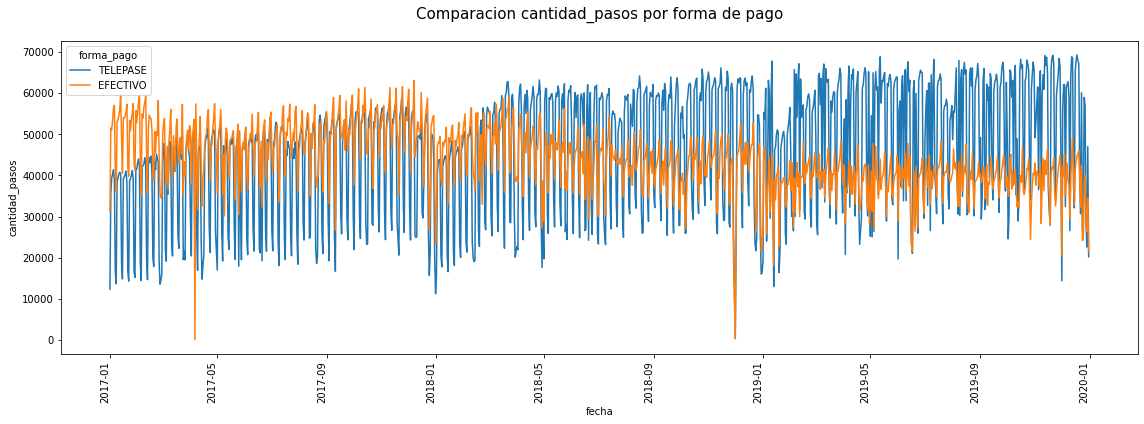

In [44]:
# Creamos una mascara para la estiacion Illia y las formas de pago EFECTIVO y TELEPASE
mask = np.logical_and(peajes_full['estacion'] == 'Illia', 
                      np.logical_or(peajes_full['forma_pago'] == 'EFECTIVO', peajes_full['forma_pago'] == 'TELEPASE'))

# Aplicamos la mascara al dataset original
peajes_illia = peajes_full[mask]
peajes_illia.sort_values('fecha', inplace = True) # ordenamos por fecha para que tenga un sentido temporal
peajes_illia['fecha'] = pd.to_datetime(peajes_illia.fecha)

# Hacemos un grafico de linea para comparar ambas formas de pago
plt.figure(figsize = (16, 6))
sns.lineplot(x = peajes_illia['fecha'], y = peajes_illia['cantidad_pasos'], hue = peajes_illia['forma_pago'], estimator = 'sum', err_style = None)
plt.xticks(rotation = 90, ha = 'right', size = 10)

plt.title('Comparacion cantidad_pasos por forma de pago', fontsize = 15, y = 1.05)
plt.tight_layout()
plt.show()

Podemos observar que existe una tendencia negativa para la forma de pago `EFECTIVO` y una tendencia positiva para `TELEPASE`. Ademas, la segunda a priori tiene una desviacion estandar mas alta que la primera.

Por ultimo, veamos las distribuciones de los datos por año:

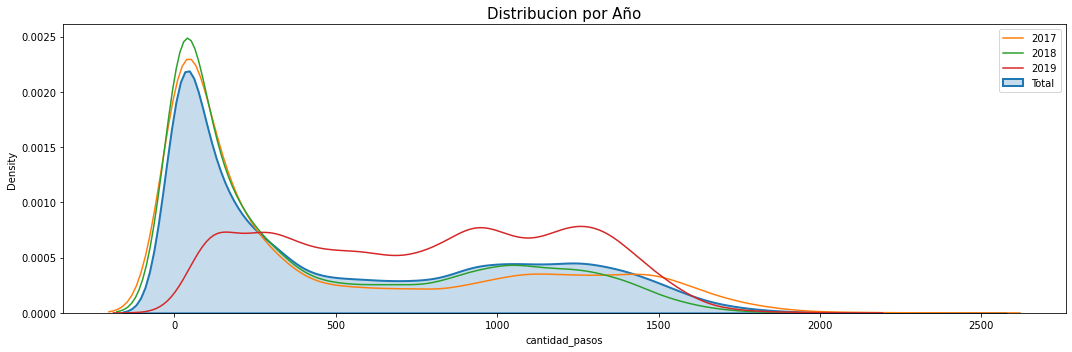

In [45]:
plt.figure(figsize = (15,5))
sns.distplot(peajes['cantidad_pasos'], label = 'Total', hist = False, kde_kws = {'lw': 2, 'shade': True}) # distribucion del total
sns.distplot(peajes[peajes['anio'] == 2017]['cantidad_pasos'], label = '2017', hist = False) # distribucion año 2017
sns.distplot(peajes[peajes['anio'] == 2018]['cantidad_pasos'], label = '2018', hist = False) # distribucion año 2018
sns.distplot(peajes[peajes['anio'] == 2019]['cantidad_pasos'], label = '2019', hist = False) # distribucion año 2019
plt.title('Distribucion por Año', fontsize = 15)
plt.legend()
plt.tight_layout()

Podemos osbervar que las distribuciones son similares, con una distribucion del `Total` con una cola larga hacia la derecha, y si bien los años `2017` y `2018` tienen una distribucion similar entre ellos y con la Total, el año `2019` tiene una distribucion mas parecida a *Uniforme*, quizas debido en cierta parte por la menor cantidad de observaciónes en relación con los años anteriores. 

<!--  -->

# **PARTE B**: Modelo de Machine Learning

Empezaremos en primer lugar por dividir el dataset con el que vamos a entrenar el modelo en train y test:

In [95]:
# Definimos los indices de los conjuntos de train y test
n_train = 0.85 # porcentaje de los datos para train
data_train = np.int(round(len(diario) * n_train, 0)) # index data train
data_test = np.int(len(diario) - data_train) # index data test

# Creamos los conjuntos de train y test
train = diario.cantidad_pasos[:data_train] # data train
test = diario.cantidad_pasos[data_train:] # data test

print(f'Shape train: {train.shape} \nShape test: {test.shape}')

Shape train: (931,) 
Shape test: (164,)


<!--  -->

El objetivo de este apartado es el desarrollo de un modelo de machine learning, en donde se analizaran componentes claves en una Serie de Tiempo como lo son la tendencia y la estacionalidad de los datos, dos caracteristicas muy importante de nuestros datos para conocer y entender el comportamiento temporal de estos.


Para esto, es necesario empezar analizando si los datos son `Estacionarios` o `No Estacionarios`, y en el caso en que sean No Estacionarios, debemos realizar algunas transformaciones para volverlos Estacionarios. Pero antes de seguir, primero hay que entender que en una Serie de Tiempo existe `autocorrelación`, es decir, que nuestro output o variable de estudio esta correlacionada consigo misma, o mejor dicho, con los datos temporalmente anteriores a esta. Segundo, los modelos de pronóstico autorregresivos son esencialmente modelos de regresión lineal en los que utiliza los retrasos o lag de la propia serie como predictores. 
Como sabemos, una regresión lineal trabaja mejor con variables que no estan correlacionadas, entonces, transformando una serie a `Estacionaria`, significa resolver los problemas de autocorrelación generando que los retrasos de la Serie de Tiempo sean independientes entre sí.

Ahora si, empezamos analizando si los datos son estacionarios o no, utilizaremos el metodo de ADFuller para determinarlo:

In [96]:
# Metodo para determinar si la serie de tiempo es estacionaria o no
resultado = kpss(train)
print('ADF Statistic: %f' % resultado[0])
print('p-value: %f' % resultado[1])
print('La serie de tiempo es estacionaria' if resultado[1] > 0.05 else 'La serie de tiempo es no-estacionaria')

ADF Statistic: 2.913236
p-value: 0.010000
La serie de tiempo es no-estacionaria


Como vemos, la serie de tiempo no es estacionaria, por lo que debemos hacer las transformaciones necesarias para volverla estacionaria.

Definiremos dos modelos el cual uno va a ser nuestro modelo benchmark (modelo ARIMA), con el ojetivo de comparar las metricas de ambos modelos. Las metricas que se utilizaran son:

- MAE/RMSE: ya que ambos errores nos arroja resultados en las mismas unidades de medida que la variable analizada, diciendonos cuantas unidades en promedio nos alejamos de la media de dicha variable.
- MAPE: ya que este error nos dice en valor de porcentaje cuanto es el error esperado del modelo.

<!--  -->

### **1) Modelo ARIMA**

El modelo benchmark que realizaremos, es un modelo ARIMA (Auto Regressive Integrated Moving Average por sus siglas en inglés), en el que debemos buscar los valores para los hiperparametros a definir para la construcción del modelo. Debemos buscar el valor `p` (para 'AR', el término autorregresivo), el valor `d` (diferenciación de la serie de tiempo) y el valor `q` (para 'MA', el termino de media móvil).

Buscaremos el valor de `d`, realizando 1° y 2° diferenciación:

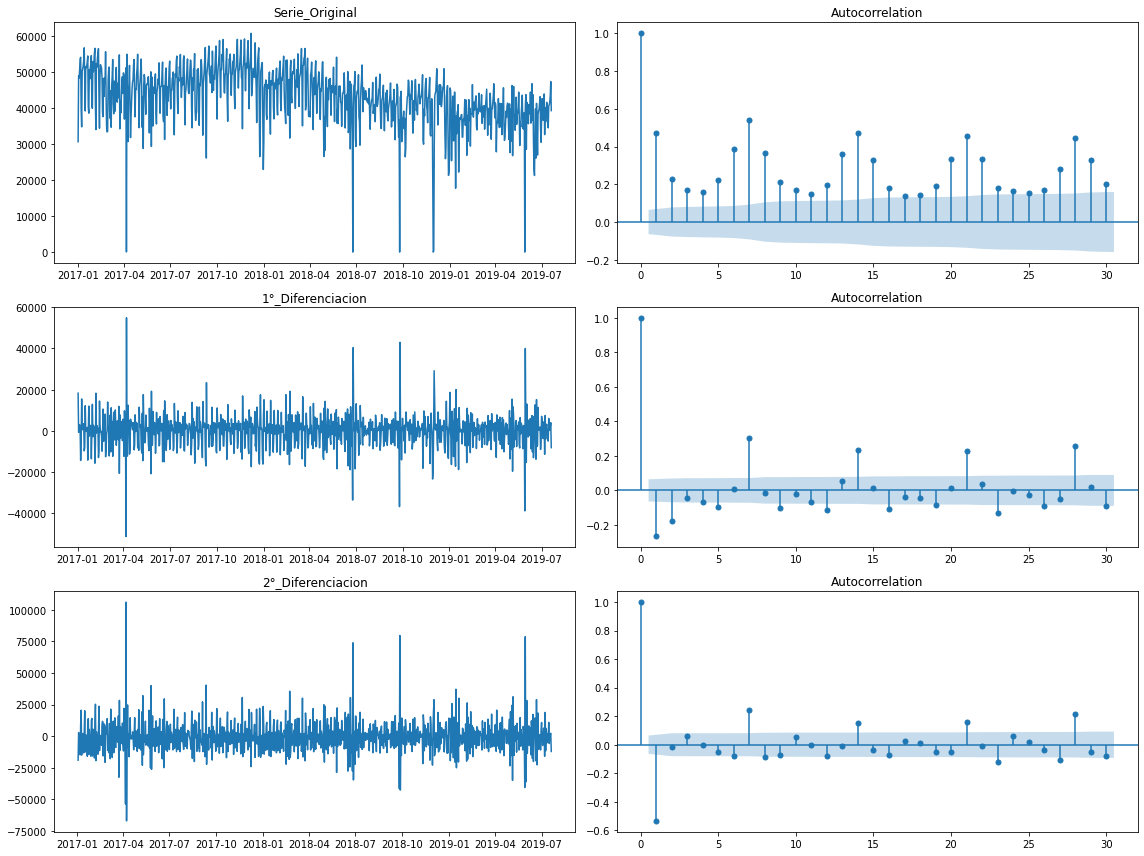

In [99]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (16, 12))

# Serie original
ax[0, 0].plot(train)
ax[0, 0].set_title('Serie_Original')
plot_acf(train, ax = ax[0, 1])

# 1° Diferenciacion
ax[1, 0].plot(train.diff())
ax[1, 0].set_title('1°_Diferenciacion')
plot_acf(train.diff().dropna(), ax = ax[1, 1])

# 2° Diferenciacion
ax[2, 0].plot(train.diff().diff())
ax[2, 0].set_title('2°_Diferenciacion')
plot_acf(train.diff().diff().dropna(), ax = ax[2, 1])

plt.tight_layout()
plt.show()

In [100]:
ndiffs(train, test='kpss')

1

Una forma de saber que diferenciacion se adapta mejor a nuestros datos es mirando el gráfico de autocorrelación, donde buscamos que el segundo lag no caiga de manera brusca hacia el negativo, y podemos ver que esto sucede en la 1° diferenciacion. Ademas, anterior a esto, utilizamos el método `KPSS` para determinar cual es la mejor diferenciacion para nuestros datos, y el resultado fue 1, mismo resultado que la observacion visual en le gráfico.

El próximo paso es encontrar el valor de `p`, para eso graficaremos la autocorrelación parcial, esto es, la correlación existente entre la serie de tiempo y los retrasos:

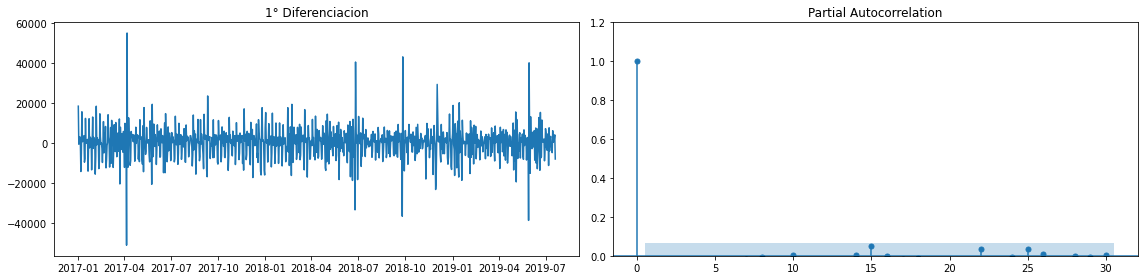

In [101]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 4))

# 1° diferenciacion
ax[0].plot(train.diff())
ax[0].set_title('1° Diferenciacion')

# Graficamos la autocorrelacion parcial
plot_pacf(train.diff().dropna(), ax = ax[1])
ax[1].set(ylim = (0, 1.2))

plt.tight_layout()
plt.show()

Podemos ver que el primer retraso o lag esta por encima del área de significancia (área celeste), por lo que podemos usar el valor de 1 para `p`.

Por último, buscaremos el valor de `q`:

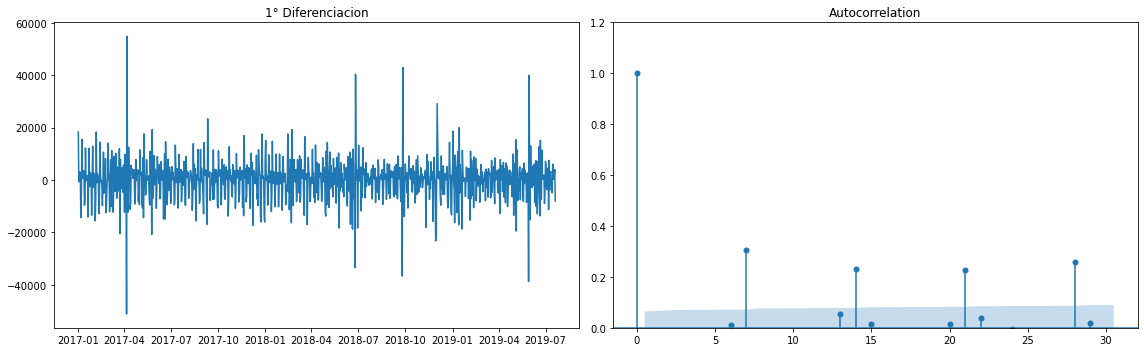

In [102]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))

ax[0].plot(train.diff())
ax[0].set_title('1° Diferenciacion')

plot_acf(train.diff().dropna(), ax = ax[1])
ax[1].set(ylim = (0, 1.2))

plt.tight_layout()
plt.show()

Nos quedaremos con el valor de `q` igual a 1.

Ahora procedemos a construir el modelo ARIMA con los valores de p, d y q encontrados anteriormente:

In [103]:
# Construccion del modelo
modelo = ARIMA(train, order = (1, 1, 1))
# Entrenamos
modelo_fit = modelo.fit()

print(modelo_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.cantidad_pasos   No. Observations:                  930
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9489.189
Method:                       css-mle   S.D. of innovations           6523.647
Date:                Wed, 19 Jan 2022   AIC                          18986.377
Time:                        20:44:22   BIC                          19005.718
Sample:                    01-02-2017   HQIC                         18993.754
                         - 07-20-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -10.3116      7.996     -1.290      0.197     -25.984       5.361
ar.L1.D.cantidad_pasos     0.2819      0.033      8.525      0.000       0.217       0.347
ma.L

Los valores de `p` y `q` podemos decir que son válidos ya que el p-value es menor que 0.05.

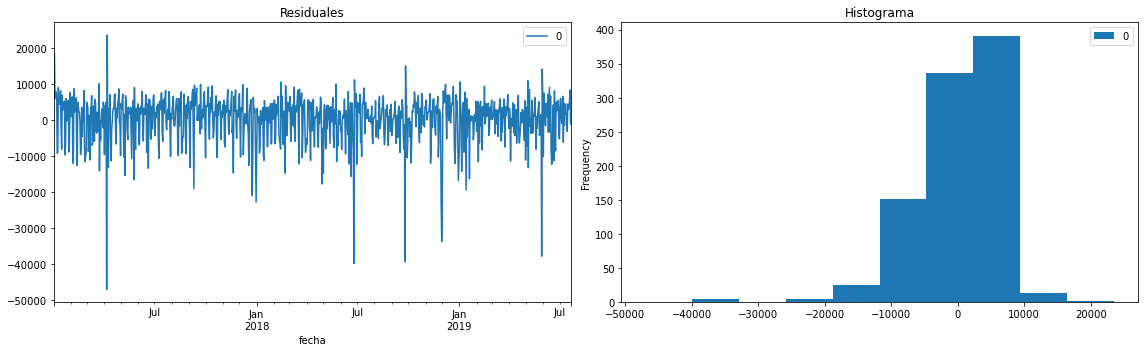

In [104]:
# Grafico de los residuales del modelo
residuals = pd.DataFrame(modelo_fit.resid)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))

residuals.plot(title = 'Residuales', ax = ax[0])
residuals.plot(kind = 'hist', title = 'Histograma', ax = ax[1])

plt.tight_layout()
plt.show()

Los residuales del modelo se distribuyen casi que de manera homogénea alrededor del cero, sin observar visualmente una tendencia de los mismos, por lo que podemos decir que los valores que se tuvieron en cuenta son correctos.

Graficamos el pronóstico sobre la serie de tiempo real:

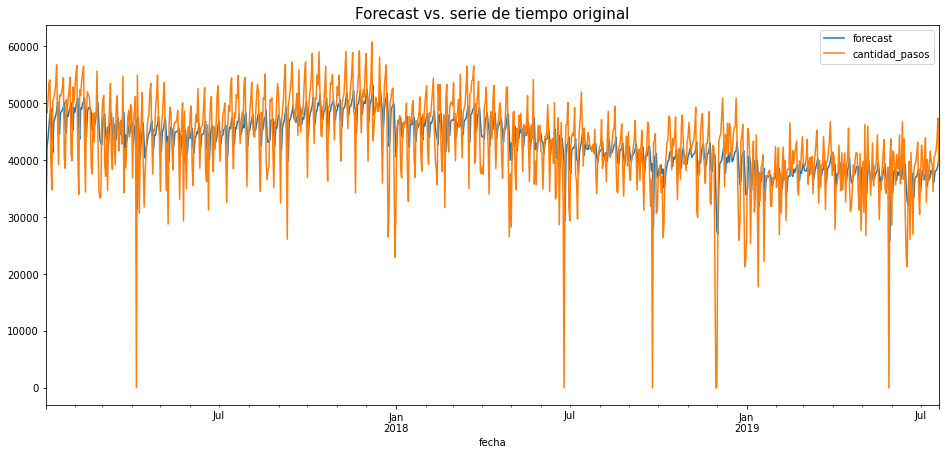

In [105]:
fig, ax = plt.subplots(figsize = (16, 7))
modelo_fit.plot_predict(ax = ax) # predicción
plt.title('Forecast vs. serie de tiempo original', fontsize = 15)
plt.show()

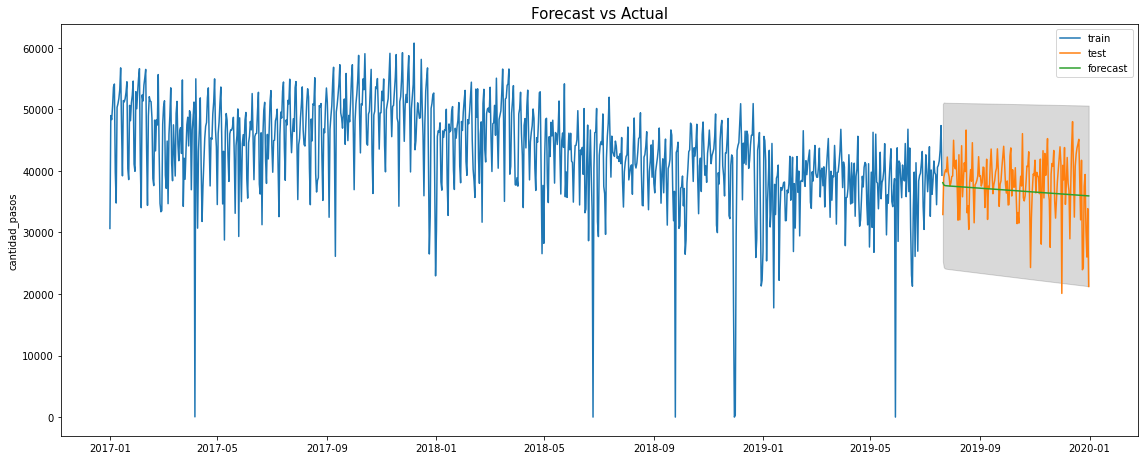

In [106]:
# Forecast
fc, se, conf = modelo_fit.forecast(data_test, alpha = 0.05)

# Make as pandas series
fc_series = pd.Series(fc, index = test.index)
lower_series = pd.Series(conf[:, 0], index = test.index)
upper_series = pd.Series(conf[:, 1], index = test.index)

# Plot
plt.figure(figsize = (16, 6.5))
plt.plot(train, label = 'train')
plt.plot(test, label = 'test')
plt.plot(fc_series, label = 'forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = 0.15)
plt.title('Forecast vs Actual', fontsize = 15)
plt.legend(loc = 'upper right', fontsize = 10)
plt.ylabel('cantidad_pasos')

plt.tight_layout()
plt.show()

In [107]:
# Calculamos los errores del modelo
print(f"El MAE en testeo es: {round(mean_absolute_error(fc, test.values), 2)}") # MAE
print(f"El MAPE en testeo es: {round(mean_absolute_percentage_error(fc, test.values), 2) * 100}") # MAPE
print(f"El RMSE en testeo es: {round(mean_squared_error(fc, test.values, squared = False), 2)}") # RMSE

El MAE en testeo es: 3769.67
El MAPE en testeo es: 10.0
El RMSE en testeo es: 4853.4


Los errores del modelo son bastante bajos, por lo que podemos decir que el modelo es aceptable.

In [108]:
# Revisa si hay algun salto temporal
# (diario.index == pd.date_range(start = diario.index.min(), end = diario.index.max(), freq = diario.index.freq)).all()

<!--  -->

### **2) Random Forest Regressor**

El modelo principal a utilizar es un Random Forest Regressor para realizar el forecast.

Empezamos creando el modelo:

In [109]:
# Regresor
regr_rf = RandomForestRegressor(random_state = 42)

# Autoregresor para forecast utilizando RandomForest como regresor
fc_rf = ForecasterAutoreg(regressor = regr_rf, 
                          lags = 164
                          )

# Grilla para definir los valores de los hiperparametros
param_grid_rf = {'n_estimators': [100, 300, 500, 700, 900],
                 'max_depth': [2, 3, 4, 5, 6]
                }
lags_grid_rf = [40, 80, 120]

# Utilizamos GridSearch para definir los mejores hiperparametros para el forecast
resultados_rf = grid_search_forecaster(forecaster = fc_rf, 
                                       y = test,
                                       param_grid = param_grid_rf,
                                       lags_grid = lags_grid_rf,
                                       steps = 164,
                                       metric = 'mean_squared_error',
                                       initial_train_size = int(len(train) * 0.15),
                                       return_best = True,
                                       verbose = False
                                       )

Number of models compared: 75


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:37<00:00, 32.65s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120] 
  params: {'max_depth': 4, 'n_estimators': 300}



In [110]:
resultados_rf.head()

,lags,params,metric,max_depth,n_estimators
61,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 4, 'n_estimators': 300}",5.039914e+07,4,300
71,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 6, 'n_estimators': 300}",5.081653e+07,6,300
66,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 300}",5.081759e+07,5,300
56,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 300}",5.111717e+07,3,300
60,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 4, 'n_estimators': 100}",5.115049e+07,4,100


Los mejores hiperparametros encontrados de acuerdo con los que se establecieron en la grilla fueron:

- lags: 120
- max_depth: 4
- n_estimators: 300

In [111]:
# Entrenamos el modelo con los mejores hiperparametros
fc_rf.fit(y = train)

In [112]:
# Realizamos las predicciones
rf_predict = fc_rf.predict(steps = int(len(test)))

In [113]:
# Calculamos los errores del modelo
print(f"El MAE en testeo es: {round(mean_absolute_error(test.values, rf_predict), 2)}") # MAE
print(f"El MAPE en testeo es: {round(mean_absolute_percentage_error(test.values, rf_predict), 2) * 100}") # MAPE
print(f"El RMSE en testeo es: {round(mean_squared_error(test.values, rf_predict, squared = False), 2)}") # RMSE

El MAE en testeo es: 3541.91
El MAPE en testeo es: 10.0
El RMSE en testeo es: 4745.99


Los errores del modelo son muy bajos, incluso mejor que el modelo ARIMA realizado, por lo que podemos decir que el modelo utilizando Random Forest Regressor es mejor que el modelo ARIMA para este dataset y para las hiperparametros definidos.

Graficamos el conjunto de datos train y tes y el forecast del conjunto de datos test:

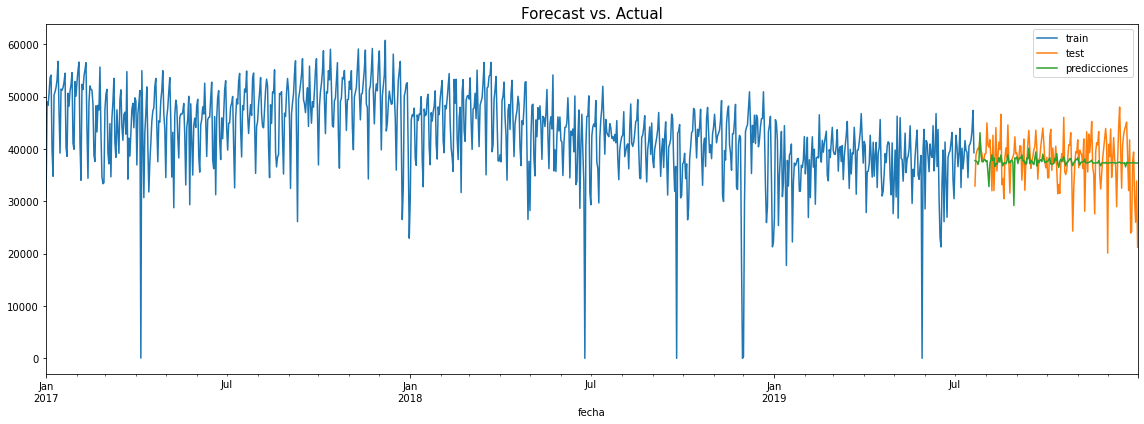

In [114]:
fig, ax = plt.subplots(figsize = (16, 6))
train.plot(ax = ax, label = 'train') # grafico del conjunto de datos de test
test.plot(ax = ax, label = 'test') # grafico del conjunto de datos de train
rf_predict.plot(ax = ax, label = 'predicciones') # grafico de las predicciones
ax.legend()
plt.title('Forecast vs. Actual', fontsize = 15)
plt.tight_layout()

<!--  -->

En el siguiente grafico podemos ver la importancia de cada uno de los retrasos o de los lag del modelo de Random Forest:

Text(0.5, 1.0, 'Importancia de cada lag')

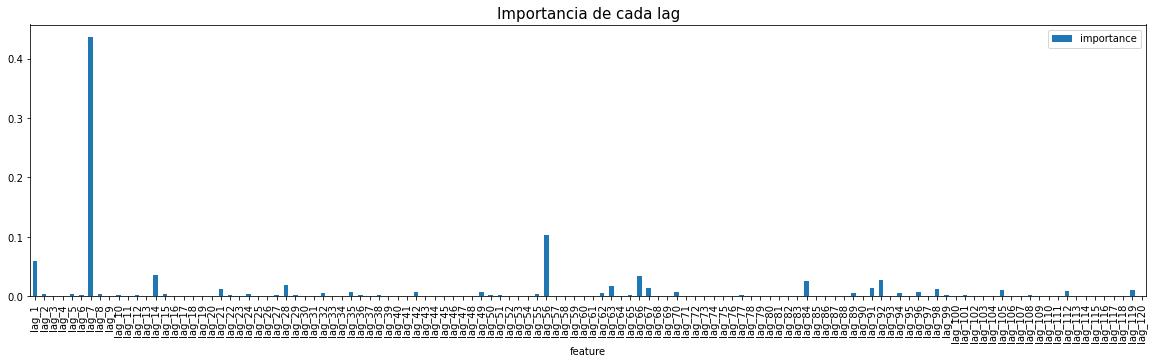

In [116]:
# Definimos la importancia de cada lag
importancia = fc_rf.get_feature_importance()
importancia.plot(x = 'feature', y = 'importance', figsize = (20, 5), kind = 'bar') # grafico de importancia de los lags
plt.title('Importancia de cada lag', fontsize = 15)

<!--  -->

# **PARTE C**: Investigación

Durante el proyecto se creo un modelo de machine learning con una única variable como input, esta es `cantidad_pasos`. Ademas, se utilizaron unicas clases de otras variables, por lo que podemos decir que estas variables tampoco tuvieron participación en el modelado. Si bien, la fecha es otra variable dentro del conjunto, la misma se la considera para darle orden temporal a la variable input que utilizamos para predecir. Pero si miramos el dataset original, vamos a encontraron tambien con las siguientes variables que pueden aportar información importante al modelo:

- Estacion: 9 categorías
- Sentido: 2 categorías
- Tipo de vehículo: 2 categorías
- Forma de pago: 8 categorías

Entonces, podemos plantear las siguientes preguntas que pueden llegar a aportar mas información al modelo y que podemos llegar a analizar con el dataset que contamos:

- ¿Qué cantidad de paso tiene cada estación? ¿Alguna tiene mas preponderancia que por sobre las demás? ¿Todas las estaciónes nos aportan la misma calidad de información? ¿O alguna habria que descartar por falta de información o desbalanceo de datos?
- ¿Como difiere la cantidad de pasos según el sentido? ¿Habrá alguna franja horaria en que haya mas pasos en un sentido que en otro? ¿Se mantiene esta tendencia durante los fines de semana?
- Al igual que con el planteo del sentido, pero agreando: ¿En qué estaciones se acentúa mas los pasos por cada tipo de vehíchulo? ¿Tendrá correlación con el sentido de los pasos?
- ¿Cuáles son las formas de pago mas utilizadas? ¿Esto cambió a lo largo de los 3 años de análisis? ¿En algúna estación se utilizará mas una forma de pago que otra?

En funcion de las preguntas planteadas, el flujo de trabajo a plantear para responder a las mismas sería el siguiente:

1) Concatenar los datasets divididos por año en un solo dataset.
2) Realizar imputación de datos faltantes en caso de ser necesario.
3) Realizar un EDA para un entendimiento mas profundo de las variables disponibles y de la relación que pueda existir entre ellas.
4) Transformar los datos en caso de ser necesario.
5) Separar el dataset en los conjuntos de datos para train y para test, definiendo un porcentaje de datos para cada uno.
6) Crear un modelo de machine learning con algun algoritmo de los disponibles para considerarlo como modelo benchmark.
7) Calcular las métricas o errores del modelo benchmark.
8) Crear otro modelo de machine learning para comprarlo con el modelo benchmark.
9) Calcular las métricas o errores del modelo.
10) Comparar ambos modelos.
11) Escribir conclusiones sobre que modelo representa mejor la variabilidad de los datos, con que variables y porqué.